In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression

# import json
# with open('510050_20230214.json') as user_file:
#   parsed_json = json.load(user_file)
# tickers = []
# for i in parsed_json["StockComponent"].keys():
#   tickers.append(i+".SH")

import tushare as ts
ts.set_token('0742c95bee169abeccdf80bbdce1b2e0cf2ac4d83cbd932b608300fd')
pro = ts.pro_api()
tickers = pro.index_weight(index_code='000016.SH', trade_date=20210630, 
                        fields=["con_code"])["con_code"].to_list()
                        
def get_returns(tickers, start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns

In [18]:
start = '20200610'
end = '20210930'
# start = '20211001'
# end = '20230228'
original_returns = get_returns(tickers, start, end)

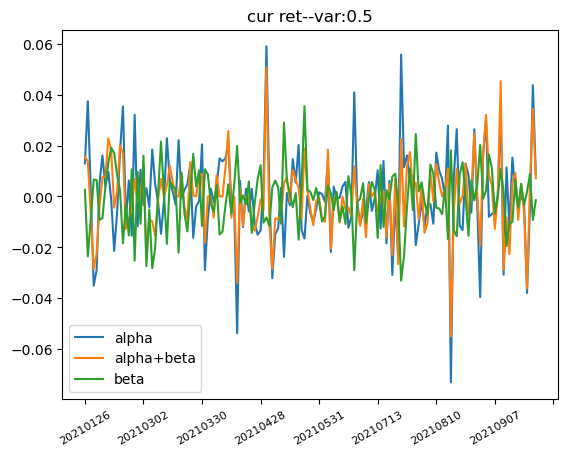

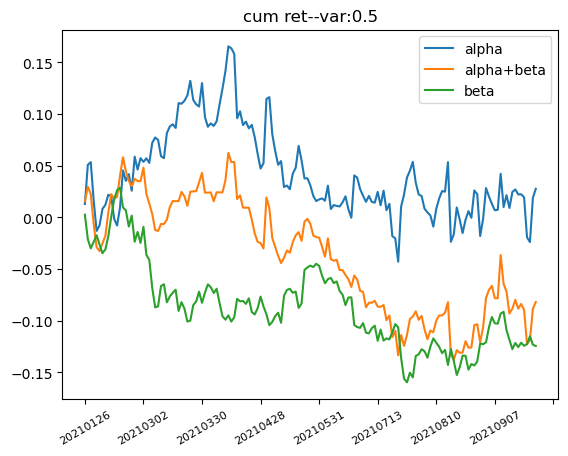

用时： 6.7900694999989355


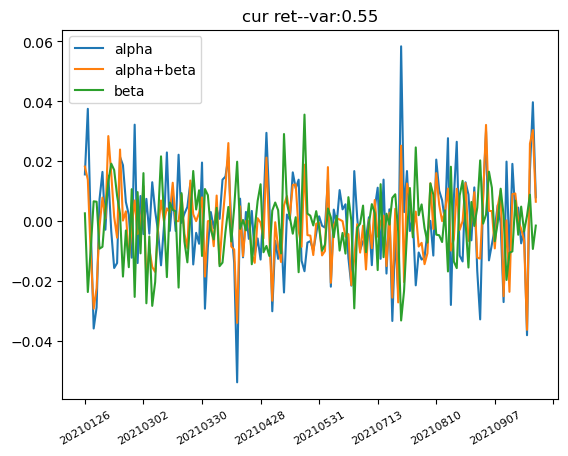

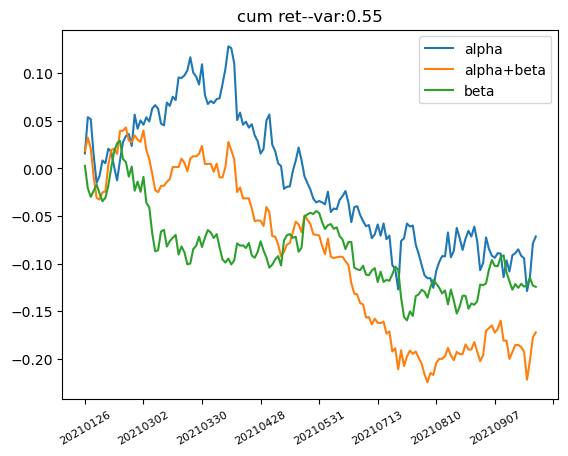

用时： 7.735837899999751


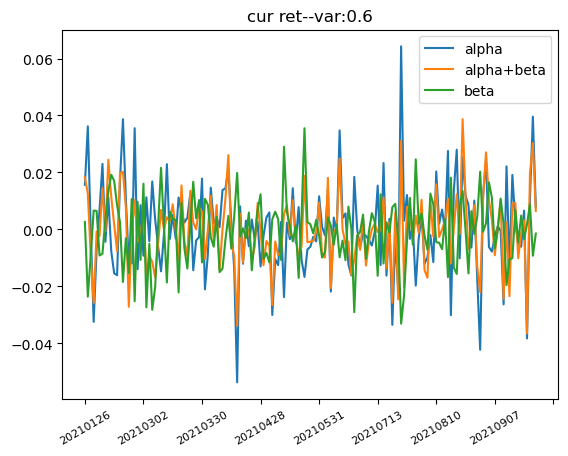

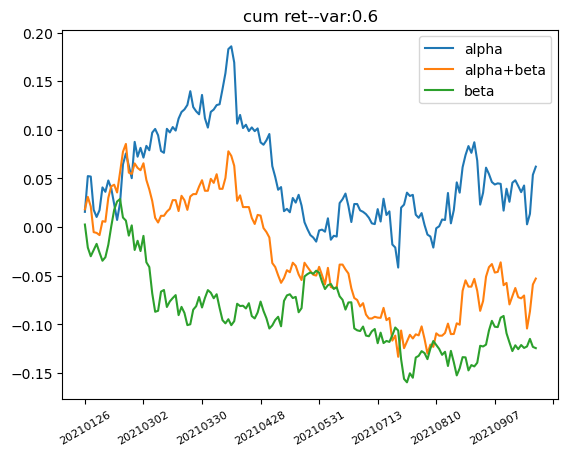

用时： 7.3041250000023865


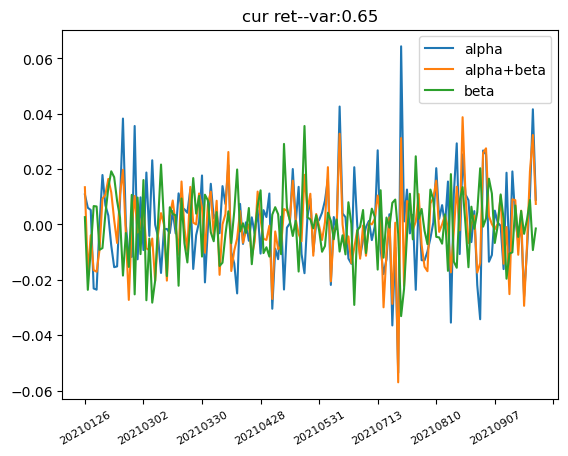

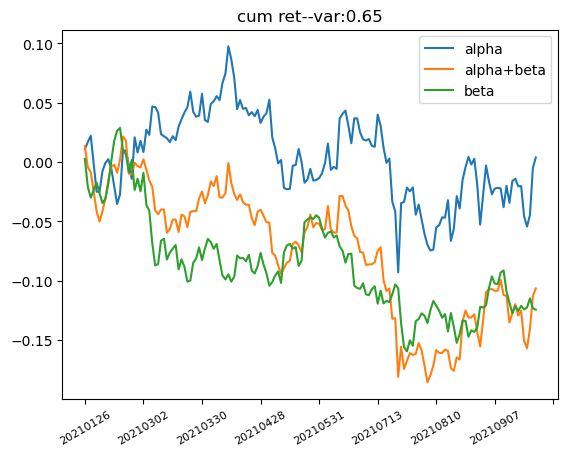

用时： 7.019604500001151


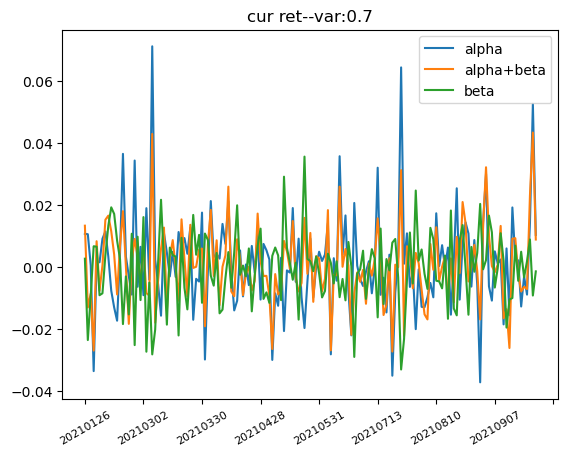

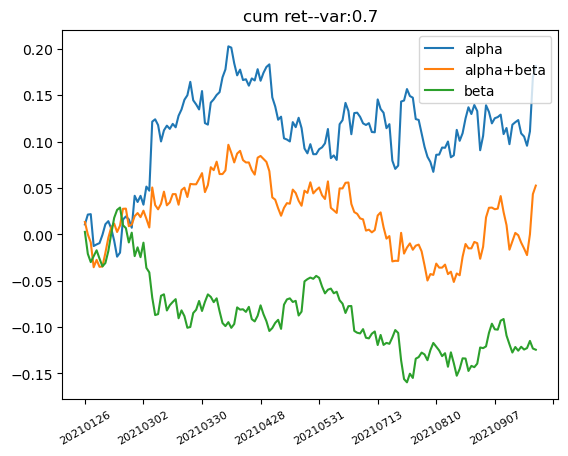

用时： 8.064031099998829


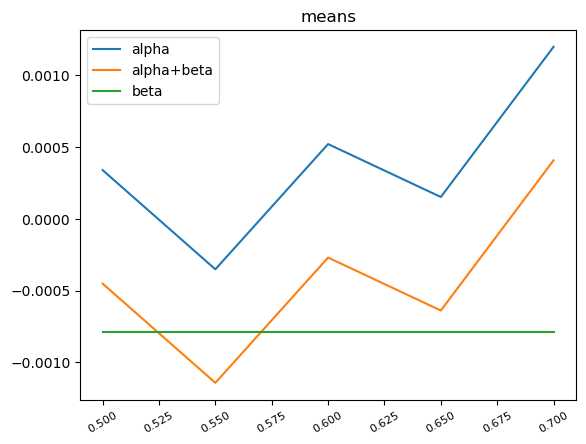

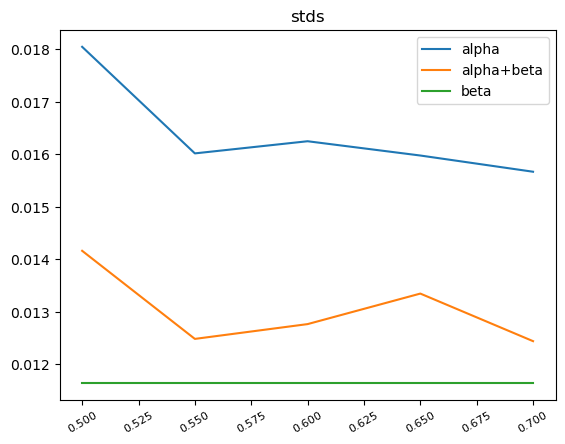

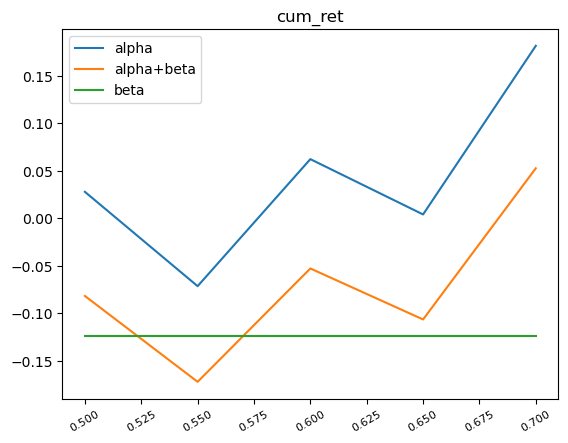

In [29]:
vars = np.array([0.5,0.55,0.6,0.65,0.7])
means = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
stds = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
cum_ret = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
for var in vars:    
    cur_ret_P = []
    cur_ret_P__ = []
    cur_ret_P_ = []
    cum_ret_P = [0]
    cum_ret_P_ = [0]
    cum_ret_P__ = [0]
    date = []
    time_length = 60 # time window
    t1 = timer()
    # num_long_short = pd.DataFrame(columns=['long','short'],index=original_returns.index)
    # z_df = pd.DataFrame(columns=original_returns.index,index=original_returns.columns)
    for cur_num in range(time_length, original_returns.shape[0]):
        date.append(original_returns.index[cur_num-1])
        # print('date:', date[-1])
        # 获取标准化实验数据
        returns = original_returns.iloc[cur_num-time_length:cur_num]
        returns = (returns - returns.mean())/returns.std()
        eigenvals, eigenvecs = np.linalg.eig(returns.corr())
        idx = eigenvals.argsort()[::-1]   
        pca_eigenvals = eigenvals[idx]/sum(eigenvals)
        for i in range(0, len(pca_eigenvals)+1):
            if sum(pca_eigenvals[:i]) >= var:
                # pca_eigenvecs = np.sqrt(eigenvals[idx][:i]) * eigenvecs[:, idx][:, :i]
                pca_eigenvecs = eigenvecs[:, idx][:, :i]
                break
        factors_P = sm.add_constant(np.dot(returns, pca_eigenvecs))
        OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
        resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
        zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
        long_P = zscores_P[zscores_P < -1.5]
        short_P = zscores_P[zscores_P > 2.5]
        # PCA选股
        if len(long_P) != 0:
            weights_long_P = long_P * (1 / long_P.sum())
            # print('long:', end=' ')
            # for stock, weight in weights_long_P.items():
            #     print(stock+': %.4f'%weight, end='  ')
        else: weights_long_P = long_P
        if len(short_P) != 0:
            weights_short_P = short_P * (1 / short_P.sum())
            # print('short:', end=' ')
            # for stock, weight in weights_short_P.items():
            #     print(stock+': %.4f'%weight, end='  ')
        else: weights_short_P = short_P
        cur_ret_P.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2 - original_returns.iloc[cur_num].mean())
        cur_ret_P_.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2)
        cur_ret_P__.append(original_returns.iloc[cur_num].mean())
        cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
        cum_ret_P_.append((1+cum_ret_P_[-1])*(1+cur_ret_P_[-1])-1)
        cum_ret_P__.append((1+cum_ret_P__[-1])*(1+cur_ret_P__[-1])-1)
        # print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
        # print('cum ret：%.4f'%cum_ret_P[-1])
        # num_long_short.loc[date[-1]] = [len(long_P),len(short_P)]
        # z_df[date[-1]] = zscores_P

    # num_long_short = num_long_short.dropna()
    # z_df = z_df.dropna(axis=1)
    df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_P_[:],cur_ret_P__[:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cur.plot()
    plt.title('cur ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()
    dcb = df_cur.describe()
    means.loc[var] = dcb.loc['mean']
    stds.loc[var] = dcb.loc['std']
    cum_ret.at[var,'alpha'] = cum_ret_P[-1]
    cum_ret.at[var,'alpha+beta'] = cum_ret_P_[-1]
    cum_ret.at[var,'beta'] = cum_ret_P__[-1]
    df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_P_[1:],cum_ret_P__[1:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cum.plot()
    plt.title('cum ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()
    t2 = timer()
    print('用时：', t2-t1)
means.plot()
plt.title('means')
plt.xticks(rotation=30, fontsize=8)
plt.show()
stds.plot()
plt.title('stds')
plt.xticks(rotation=30, fontsize=8)
plt.show()
cum_ret.plot()
plt.title('cum_ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

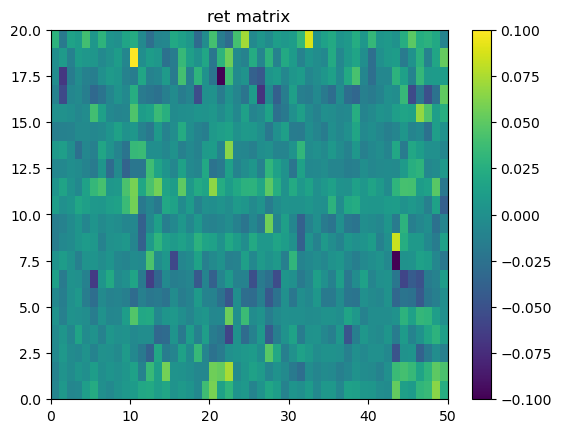

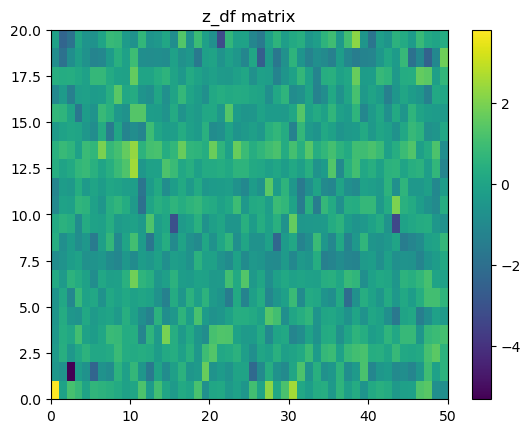

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH,...,601688.SH,601818.SH,601857.SH,601888.SH,601899.SH,601995.SH,603259.SH,603288.SH,603501.SH,603986.SH
600000.SH,0.902079,0.171398,0.391462,-0.438447,0.182875,-0.001815,0.450903,0.267392,-0.360402,0.223020,...,0.045401,0.270284,-0.142812,-0.096753,-0.532621,0.182074,0.262795,0.298612,0.254538,-0.431593
600009.SH,0.279104,0.990627,0.632131,-0.066740,0.615962,0.542195,0.469994,0.073762,-0.070783,0.286911,...,0.795894,0.478415,0.067570,-0.150333,-0.045706,0.665316,0.041126,0.413687,0.389860,-0.482080
600016.SH,0.502158,0.521733,0.889887,-0.136995,0.335873,0.126337,0.345347,-0.138100,-0.427376,0.272855,...,0.506438,0.248301,0.245338,-0.201475,-0.222275,0.334277,-0.008612,0.186786,-0.009320,-0.466389
600028.SH,-0.368654,-0.186897,-0.152586,0.810741,0.113896,0.163716,-0.418331,-0.067284,0.114676,0.354643,...,0.128570,-0.458562,0.547645,0.252264,0.126611,-0.167774,-0.019796,0.091079,0.213575,0.068270
600030.SH,0.258059,0.648056,0.441179,0.255504,0.994014,0.713584,0.439390,0.386814,0.514449,0.751706,...,0.829200,0.588437,0.205191,0.252593,0.352802,0.620497,0.209993,0.347881,0.529708,-0.493820
600031.SH,0.115210,0.586917,0.319559,0.395617,0.659645,0.929005,0.506095,0.256055,0.521372,0.416848,...,0.555031,0.735678,0.395151,0.129479,0.624854,0.646180,0.493640,0.512291,0.401334,-0.269951
600036.SH,0.733870,0.504615,0.522615,-0.274848,0.403484,0.403529,0.974668,0.265647,0.073055,0.360568,...,0.411937,0.712773,-0.098875,0.097125,-0.030553,0.686498,0.277065,0.367936,0.411703,-0.550619
600048.SH,0.292730,-0.033596,-0.187784,-0.109208,0.273460,0.099621,0.045476,0.873985,0.083654,0.489974,...,0.062708,-0.133213,-0.141907,0.162951,-0.285793,-0.136601,-0.135874,0.139528,0.306318,-0.170055
600050.SH,-0.184780,-0.157582,-0.362257,0.385893,0.436721,0.280820,-0.025029,0.361880,0.845044,0.574882,...,0.220017,-0.039492,-0.042271,0.418502,0.315341,0.011575,-0.016172,-0.262501,0.386601,-0.134105
600104.SH,0.208617,0.258636,0.244804,0.341286,0.764087,0.495366,0.304439,0.504396,0.460146,0.998340,...,0.627422,0.287801,0.214900,0.288145,0.309897,0.249696,-0.062476,0.182558,0.576670,-0.337464


In [5]:
ret = original_returns.iloc[101:121]
z_df = (z_df.T.iloc[:20])
plt.pcolormesh(ret)
plt.colorbar()
plt.title('ret matrix')
plt.show()
plt.pcolormesh(z_df)
plt.colorbar()
plt.title('z_df matrix')
plt.show()
pd.concat([ret, z_df], axis=1, keys=['ret', 'z_df']).corr().loc['ret', 'z_df']

In [6]:
t = z_df.describe()
print(t.loc['min'].min(),t.loc['max'].max())
t

-5.31755163800653 3.821540747368778


,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH,...,601688.SH,601818.SH,601857.SH,601888.SH,601899.SH,601995.SH,603259.SH,603288.SH,603501.SH,603986.SH
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.069112,-0.208855,-0.453979,0.005053,-0.081217,-0.357395,0.016414,0.129699,0.206985,0.072862,...,-0.177594,-0.069944,-0.100489,-0.309624,0.082910,-0.061645,-0.036859,0.067645,-0.020226,0.120842
std,1.077220,0.806189,1.343894,0.671982,0.490039,0.790703,0.664055,0.640612,0.685888,0.620989,...,0.658702,0.467253,0.542036,1.054251,0.593491,0.763788,0.818411,1.020012,0.751444,0.726802
min,-1.143498,-2.375010,-5.317552,-1.703119,-0.715711,-2.378173,-1.102132,-1.550303,-1.109797,-1.188767,...,-1.757711,-0.817657,-1.359036,-3.329849,-1.469420,-1.901120,-1.445620,-2.482507,-1.048245,-1.154960
25%,-0.670073,-0.430697,-0.587848,-0.233271,-0.490114,-0.717199,-0.332482,-0.039161,-0.209788,-0.224375,...,-0.369824,-0.436335,-0.474202,-0.682141,-0.067181,-0.375641,-0.508234,-0.608135,-0.489530,-0.368600
50%,-0.364137,-0.045112,-0.224188,0.041786,-0.110836,-0.333832,-0.040825,0.300243,0.154030,-0.034922,...,-0.167311,-0.074029,-0.053747,-0.406452,0.139210,0.096757,-0.112806,0.020743,-0.134906,0.166349
75%,0.356424,0.304232,0.222929,0.423029,0.175886,0.118613,0.150509,0.469519,0.745037,0.312884,...,0.107300,0.181155,0.282645,0.238096,0.510049,0.397985,0.536179,1.001040,0.307095,0.581079
max,3.821541,0.840294,1.120226,1.040390,0.863945,0.763457,1.974273,0.877515,1.451948,1.622061,...,1.203343,0.887295,0.626045,2.010943,0.907962,1.295302,1.623896,1.485917,1.482883,1.819253


In [ ]:
cur_ret_H = []
cur_ret_P = []
cum_ret_H = [0]
cum_ret_P = [0]
date = []
nb_clusters = 19 # HPCA分层数
num_components = 50 # 选择主成分数量
time_length = 252 # 一次实验的时间跨度
t1 = timer()

for cur_num in range(time_length, original_returns.shape[0]):
    date.append(original_returns.index[cur_num-1])
    print('date:', date[-1])
    # 获取标准化实验数据
    returns = original_returns.iloc[cur_num-time_length:cur_num]
    returns = (returns - returns.mean())/returns.std()

    ########################################################
    ###HPCA分层方法
    # 对相关系数分层
    corr = returns.corr(method='pearson')   # 股票returns的相关系数
    dist = 1 - corr.values
    tri_a, tri_b = np.triu_indices(len(dist), k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
    sorted_stocks = returns.columns[permutation]
    sorted_corrs = corr.values[permutation, :][:, permutation]
    sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强
    clustering_inds = hierarchy.fcluster(linkage, nb_clusters,criterion='maxclust')
    clusters = {i: [] for i in range(min(clustering_inds),
                                    max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(i)
    permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                        key=lambda x: x[0], reverse=False)
    # 分层股票代码
    sorted_clusters = {}
    for cluster in clusters:
        sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    # 分层第一特征向量
    eigen_clusters = {}
    for cluster in clusters:
        cluster_members = sorted_correlations.columns[
            sorted_clusters[cluster]].tolist()
        corr_cluster = sorted_correlations.loc[cluster_members, cluster_members]
        cluster_returns = returns[cluster_members]
        eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values) # 簇内相关系数的特征值、特征向量
        idx = eigenvals.argsort()[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        val1, vec1= eigenvals[0], eigenvecs[:, 0] # 簇内相关系数的最大特征值、第一特征向量
        F1 = (1 / np.sqrt(val1)) * np.dot(cluster_returns.values,vec1) # 簇内降维后得到的收益率 392*10 × 10*1 = 392*1 F1称为降维收益率
        eigen_clusters[cluster] = F1
    # 股票对应分层
    stock_to_cluster = {}
    for cluster in sorted_clusters:
        cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
        for stock in cluster_members:
            stock_to_cluster[stock] = cluster
    # 股票收益率和对应簇内降维收益率的线性回归斜率
    betas = {}
    for stock in returns.columns:
        stock_returns = returns[stock]
        cluster_F1 = eigen_clusters[stock_to_cluster[stock]]
        reg = LinearRegression(fit_intercept=False).fit(cluster_F1.reshape(-1, 1), stock_returns)
        beta = reg.coef_[0]
        betas[stock] = beta
    # HPCA相关系数
    HPCA_corr = sorted_correlations.copy()
    for stock_1 in HPCA_corr.columns:
        beta_1 = betas[stock_1]
        F1_1 = eigen_clusters[stock_to_cluster[stock_1]]
        for stock_2 in HPCA_corr.columns:
            beta_2 = betas[stock_2]
            F1_2 = eigen_clusters[stock_to_cluster[stock_2]]
            if stock_to_cluster[stock_1] != stock_to_cluster[stock_2]: # 对不同簇股票的相关系数调整 体现簇间差异
                rho_sector = np.corrcoef(F1_1, F1_2)[0, 1]
                mod_rho = beta_1 * beta_2 * rho_sector
                HPCA_corr.at[stock_1, stock_2] = mod_rho
    ########################################################

    ########################################################
    # HPCA建模
    model_H = PCA().fit(HPCA_corr)
    factors_H = sm.add_constant(np.dot(returns, model_H.components_.T)[:,num_components])
    OLSmodels_H = {stock: sm.OLS(returns[stock], factors_H).fit() for stock in returns.columns} # 股票收益率和对应簇的降维收益率做线性回归
    resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()})
    zscores_H = ((resids_H - resids_H.mean()) / resids_H.std()).iloc[-1].sort_values() 
    long_H = zscores_H[zscores_H < -1.5]
    short_H = zscores_H[zscores_H > 2]
    # PCA建模
    model_P = PCA().fit(sorted_correlations)
    factors_P = sm.add_constant(np.dot(returns, model_P.components_.T)[:,num_components])
    OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
    resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
    zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1].sort_values()  
    long_P = zscores_P[zscores_P < -1.5]
    short_P = zscores_P[zscores_P > 2]
    #we choose as entry point for trading any residual 
    #that deviates by 1.25 standard deviations from equilibrium, 
    #and we exit trades if the residual is less than 0.5 standard deviations
    #from equilibrium,uniformly across all stocks.

    ########################################################

    ########################################################
    # HPCA选股
    print('HPCA：', end='')
    if len(long_H) != 0:
        weights_long_H = long_H * (1 / long_H.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_H = long_H
    if len(short_H) != 0:
        weights_short_H = short_H * (1 / short_H.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_H = short_H
    cur_ret_H.append((sum(weights_long_H*original_returns[weights_long_H.index].iloc[cur_num]) - sum(weights_short_H*original_returns[weights_short_H.index].iloc[cur_num]))/2 - original_returns.iloc[cur_num].mean())
    cum_ret_H.append((1+cum_ret_H[-1])*(1+cur_ret_H[-1])-1)
    print('cur ret：%.4f'%cur_ret_H[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_H[-1])
    # PCA选股
    print('PCA：', end='')
    if len(long_P) != 0:
        weights_long_P =  long_P * (1 / long_P.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_P = long_P
    if len(short_P) != 0:
        weights_short_P =  short_P * (1 / short_P.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_P = short_P
    cur_ret_P.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2 - original_returns.iloc[cur_num].mean())
    cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
    print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_P[-1])
    ########################################################

t2 = timer()
print('用时：', t2-t1)

### 画图
df1 = pd.DataFrame(np.array([cum_ret_H[1:],cum_ret_P[1:]]).T, columns=['HPCA', 'PCA'], index=np.array(date))
df1.plot()
plt.title('cum ret--time length:{}'.format(time_length))
plt.xticks(rotation=30, fontsize=8)
plt.show()
df2 = pd.DataFrame(np.array([cur_ret_H[:],cur_ret_P[:]]).T, columns=['HPCA', 'PCA'], index=np.array(date))
df2.plot()
plt.title('cur ret--time length:{}'.format(time_length))
plt.xticks(rotation=30, fontsize=8)
plt.show()

In [ ]:
resids_H.describe()['600519.SH']

In [ ]:
zscores_H

In [ ]:
for i,j in dic: